In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
from datetime import datetime
import os,sys

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [66]:
import tensorflow as tf
from keras.layers import (
    Input,
    LSTM,
    Dropout,
    Dense
)
from keras.models import (
    Model,
    Sequential,
    load_model
)
from tensorflow.keras.callbacks import (
    Callback,
    TensorBoard,
    EarlyStopping
)

In [67]:
def locate_input_file(input_file_name="gold_price_2013_2023.csv"):
    try:
        dir_name=os.getcwd()
        input_file_path=os.path.join(dir_name,input_file_name)
        # print(input_file_path)
        return input_file_path
    
    except Exception as e:
        print(f"error : {e}")

In [68]:
def get_input_data(file_path):
    
    try:
        df=pd.read_csv(file_path)
        return df
    
    except Exception as e:
        print(f"error : {e}")



In [69]:
def print_details(df):
    try:
        print(f"shape of df : {df.shape}\n")
        print(f"columns of df : {df.columns}\n\n")
        print(f"information about df : \n{df.info()}\n\n")
        print(f"description about df : \n{df.describe()}\n\n")
        print(f"head of df : \n{df.head()}\n\n")
        print(f"tail of df : \n{df.tail()}\n\n")

        for col in df.columns:    
            print(f"value count of df : \n {df[col].value_counts()}")    

    except Exception as e:
        print(f"error : {e}")

In [70]:
def remove_unwanted_columns(df,unwanted_columns):
    try:
        # unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        unwanted_count=len(unwanted_columns)
        # print(unwanted_count)
        temp_count=0
        for col in unwanted_columns:
            if col in df.columns:
                temp_count+=1

        
        if temp_count==unwanted_count :
            print(f"all unwanted columns can be removed.")
        else:
            print(f"all unwanted columns can not be removed.")

        df=df.drop(columns=unwanted_columns,axis=1)

        return df
    
    except Exception as e:
        print(f"error : {e}")

In [71]:
def sort_date(df):
    try:
        df.sort_values(
            by=["Date"],
            axis=0,
            ascending=True,
            inplace=True
        )
        return df

    except Exception as e:
        print(f"error : {e}")

In [ ]:
def clean_data(df):
    try:
        df["Date"]=pd.to_datetime(df["Date"])
        df["Price"]=df["Price"].str.replace(",","").astype(float)
        df=sort_date(df)

        scaler=MinMaxScaler()
        df["Price"]=scaler.fit_transform(df[["Price"]])

        return df,scaler

    except Exception as e:
        print(f"error : {e}")

In [73]:
def handle_missing(df):
    try:
        print(f"Column-wise missing values:\n{df.isnull().sum()}\n")
        print(f"Total missing values: {df.isnull().sum().sum()}\n")

        num_cols = df.select_dtypes(include=["int64", "float64"]).columns
        cat_cols = df.select_dtypes(include="object").columns

        print(f"Numerical columns: {list(num_cols)}")
        print(f"Categorical columns: {list(cat_cols)}")

        # Fill missing values
        for col in num_cols:
            df[col] = df[col].fillna(df[col].mean())

        for col in cat_cols:
            df[col] = df[col].fillna(df[col].mode()[0])

        return df

    except Exception as e:
        print("Error:", e)


In [74]:
def handle_duplicate(df):
    try:
        duplicate_count=df.duplicated().sum()
        print(f"duplicated  values : {duplicate_count}")
        
        if duplicate_count>0:
            df.drop_duplicates(ignore_index=True)

        return df

    except Exception as e:
        print(e)

In [75]:
def plot_figure(df):
    try:
        test_size=df[df["Date"].dt.year==2022].shape[0]
            
        plt.figure(
            figsize=(15,6),
            dpi=150
        )
        plt.rcParams["axes.facecolor"] = "pink"
        plt.rcParams["axes.edgecolor"] = "white"
        
        plt.plot(
            df["Date"][:-test_size],
            df["Price"][:-test_size],
            color="blue",
            lw=2        
        )
        plt.plot(
            df["Date"][-test_size:],
            df["Price"][-test_size:],
            color="yellow",
            lw=2
        )
        plt.title("gold price",fontsize=36)
        plt.xlabel("Date",fontsize=12)
        plt.ylabel("Price",fontsize=12)
        plt.legend(
            [
                "Training set",
                "Test set"
            ],
            loc="upper left",
            prop={"size":15}
        )
        plt.grid(color="white")
        plt.show()

    except Exception as e:
        print(f"error  : {e}")

In [76]:
def build_train_test_dataset(df,test_size,window):
    try:
        train_data=df["Price"][:-test_size].to_numpy().reshape(-1,1)
        x_train=[]
        y_train=[]

        for i in range(window,len(train_data)):
            x_train.append(train_data[i-window:i,0])
            y_train.append(train_data[i,0])


        x_train=np.array(x_train)
        y_train=np.array(y_train)

        print(f"x_train shape :{x_train.shape}")
        print(f"y_train shape :{y_train.shape}")


        
        test_data=df["Price"][-test_size-window:].to_numpy().reshape(-1,1)
        x_test=[]
        y_test=[]

        for i in range(window,len(test_data)):
            x_test.append(test_data[i-window:i,0])
            y_test.append(test_data[i,0])

        x_test=np.array(x_test)
        y_test=np.array(y_test)


        print(f"x_test shape :{x_test.shape}")
        print(f"y_test shape :{y_test.shape}")


        return x_train,y_train,x_test,y_test

    except Exception as e:
        print(f"error : {e}")

In [77]:
def get_recent_log_dir():
    try:
        log_path = os.path.join(os.getcwd(), "log","fit")
        log_files = sorted(os.listdir(log_path))
        return os.path.join(log_path, log_files[-1])

    except Exception as e:
        print(f"error : {e}")

def launch_tensorboard():
    try:
        ipython = get_ipython()

        # Load or reload the extension
        try:
            ipython.run_line_magic('reload_ext', 'tensorboard')
        except:
            ipython.run_line_magic('load_ext', 'tensorboard')

        # Get latest log directory
        log_dir = get_recent_log_dir()
        print("Launching TensorBoard at:", log_dir)

        # Start TensorBoard
        ipython.run_line_magic('tensorboard', f'--logdir "{log_dir}"')

    except Exception as e:
        print(f"error : {e}")

In [78]:
def get_tensorboard_callback():
    try:
        tensor_file_name=datetime.now().strftime("%d_%m_%y__%H_%M_%S")
        log_file= "log"

        log_path=os.path.join(os.getcwd(),log_file,"fit",tensor_file_name)
        dir_name=os.path.dirname(log_path)
        
        os.makedirs(
            dir_name,
            exist_ok=True
        )

        # return TensorBoard(
        #         log_dir=log_path,
        #         histogram_freq=1
        # )


        return TensorBoard(
            log_dir=log_path,
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            profile_batch=0  # Set to 0 or specific batch index for profiling
        )
    
    except Exception as e:
        print(f"error : {e}")

In [79]:
def get_early_stopping_callback():
    try :
        early_stopping_callback=EarlyStopping(
            monitor="val_loss",
            patience=100,
            restore_best_weights=True,
        )
        return  early_stopping_callback

    except Exception as e:
        print(f"error : {e}")

In [80]:
def build_lstm_model(window):
    try:
        input1=Input(shape=(window,1))
        x=LSTM( 
            units=64,
            return_sequences=True
        )(input1)
        x=Dropout(.2)(x)
        x=LSTM(
            units=64,
            return_sequences=True
        )(x)
        x=Dropout(0.2)(x)
        x=LSTM(
            units=64,
            return_sequences=False
        )(x)
        x=Dropout(.2)(x)
        x=Dense(
            units=32,
            activation="softmax"
        )(x)
        dnn_output=Dense(1)(x)


        model=Model(
            inputs=input1,
            outputs=[dnn_output]
        )
        model.compile(
            loss="mean_squared_error",
            optimizer="Nadam"
        )
        model.summary()

        return model
    

    except Exception as e:
        print(f"error : e")

In [81]:
def compile_model(model):
    try:
        model.compile(
            optimizer="adam",
            loss="mae",
            metrics=["mae","mse"]
        )

        return model

    except Exception as e:
        print("error : {e}")

In [ ]:
def run_model(model,x_train,y_train,epochs):
    try:
        start_time=datetime.now()
        history=model.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=100,
            validation_split=0.2,
            verbose=1,
            callbacks=[
                get_tensorboard_callback(),
                get_early_stopping_callback()
            ]
        )
        end_time=datetime.now()

        print(f"time taken to run the model : {end_time - start_time}")

        return history

    except Exception as e:
        print(f"error : {e}")

In [83]:
# def evaluate_history(history):
#     try:
#         history_data = history.history
#         keys = list(history_data.keys())

#         plt.figure(figsize=(10, 6))
#         plt.title("Model Training Metrics")
#         plt.xlabel("Epoch")
#         plt.ylabel("Metric Value")

#         for key in keys:
#             plt.plot(history_data[key], label=key)

#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#     except Exception as e:
#         print(f"History evaluation error: {e}")


In [84]:
def show_history(history):
    try:
        history_data = history.history
        keys = list(history_data.keys())
        
        validation_keys=[k for k in keys if k.startswith("val_")]
        training_keys=[k for k in keys if not k.startswith("val_") ]

        for key in keys:
            plt.figure(figsize=(5, 3))
            plt.xlabel("Epoch")
            plt.ylabel(f"{key}")
            plt.plot(history_data[key], label=key)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        for key1,key2 in zip(training_keys,validation_keys):
            plt.figure(figsize=(5, 3))
            plt.xlabel("Epoch")
            # plt.ylabel(f"{key}")
            plt.plot(history_data[key1], label=key1)
            plt.plot(history_data[key2], label=key2)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            

    except Exception as e:
        print(f"History evaluation error: {e}")


In [85]:
# 

In [86]:
def save_history_csv(history, file_path):
    try:
        df = pd.DataFrame(history.history)
        df.to_csv(file_path, index=False)
        
        print(f"History saved as CSV at {file_path}")
    except Exception as e:
        print(f"Error saving history as CSV: {e}")


In [87]:
def history_details(history):
    try:
        file_name=datetime.now().strftime("history%d_%m_%y__%Hh_%Mm_%Ss")+".csv"
        file_path=os.path.join(os.getcwd(),"history",file_name)
        file_dir=os.path.dirname(file_path)
        os.makedirs(
            file_dir,
            exist_ok=True
        )

        save_history_csv(history,file_path)
        show_history(history)
            

    except Exception as e:
        print(f"History evaluation error: {e}")


In [88]:
def evaluate_model():
    try:
        # evaluate_history()
        launch_tensorboard()

    except Exception as e:
        print(f"error : {e}")

In [89]:
def run_training():
    try:
        input_file_path=locate_input_file()
        print(input_file_path)  


        df=get_input_data(input_file_path)
        print_details(df)

        unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        df=remove_unwanted_columns(df,unwanted_columns)
        print_details(df)

        df=clean_data(df)
        print(df.head())
        print(df.tail())
        

        df=handle_missing(df)

        df=handle_duplicate(df)

        plot_figure(df)


        test_size=df[df["Date"].dt.year==2022].shape[0]
        window=60

        print(test_size,window)


        x_train,y_train,x_test,y_test=build_train_test_dataset(
            df,
            test_size,
            window
        )

        model=build_lstm_model(window)

        model=compile_model(model)

        model_file_name=f"model_{window}_.keras"
        model.save(model_file_name)

        epochs=50

        history=run_model(
            model,
            x_train,
            y_train,
            epochs
        )

        history_details(history)

        evaluate_model()




    except Exception as e:
        print(f"error : {e}")

In [90]:
# run_training()

In [91]:
def test_training():
    try:
        input_file_path=locate_input_file()
        print(input_file_path)  


        df=get_input_data(input_file_path)
        print_details(df)

        unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        df=remove_unwanted_columns(df,unwanted_columns)
        print_details(df)

        df=clean_data(df)
        print(df.head())
        print(df.tail())
        

        df=handle_missing(df)

        df=handle_duplicate(df)

        plot_figure(df)


        test_size=df[df["Date"].dt.year==2022].shape[0]
        window=60

        print(test_size,window)


        x_train,y_train,x_test,y_test=build_train_test_dataset(
            df,
            test_size,
            window
        )

        # model=build_lstm_model(window)

        # model=compile_model(model)

        # model_file_name=f"model_{window}_.h5"
        # model.save(model_file_name)

        # epochs=50

        # history=run_model(
        #     model,
        #     x_train,
        #     y_train,
        #     epochs
        # )

        # history_details(history)

        # evaluate_model()




    except Exception as e:
        print(f"error : {e}")

In [92]:
def build_model_pipeline():
    try:
        input_file_path = locate_input_file()
        print(input_file_path)

        df = get_input_data(input_file_path)
        print_details(df)

        unwanted_columns = ['Open', 'High', 'Low', 'Vol.', 'Change %']
        df = remove_unwanted_columns(df, unwanted_columns)
        print_details(df)

        df = clean_data(df)
        print(df.head())
        print(df.tail())

        df = handle_missing(df)
        df = handle_duplicate(df)

        plot_figure(df)

        test_size = df[df["Date"].dt.year == 2022].shape[0]

        windows = [5, 20, 60, 120, 240]
        epochs = 300
        testing_data = []
        real_data = []

        for window in windows:
            x_train, y_train, x_test, y_test = build_train_test_dataset(
                df,
                test_size,
                window
            )
            testing_data.append(x_test[0])
            real_data.append(y_test[0])

            model = build_lstm_model(window)  # renamed to avoid conflict
            model = compile_model(model)

            history = run_model(
                model,
                x_train,
                y_train,
                epochs=epochs
            )

            model_file_name = f"model_{window}_.keras"
            model.save(model_file_name)

        for data in testing_data:
            print(data)

        for data in real_data:
            print(data)

    except Exception as e:
        print(f"error: {e}")


e:\data_science_play_ground\gold_price_prediction\gold_price_2013_2023.csv
shape of df : (2583, 7)

columns of df : Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB
information about df : 
None


description about df : 
              Date     Price      Open      High       Low   Vol. Change %
count         2583      2583      2583      2583      2583   2578     2583
unique        2583      2072      2061      2044      2019   1550      474
top     12/30/2022  1,294.30

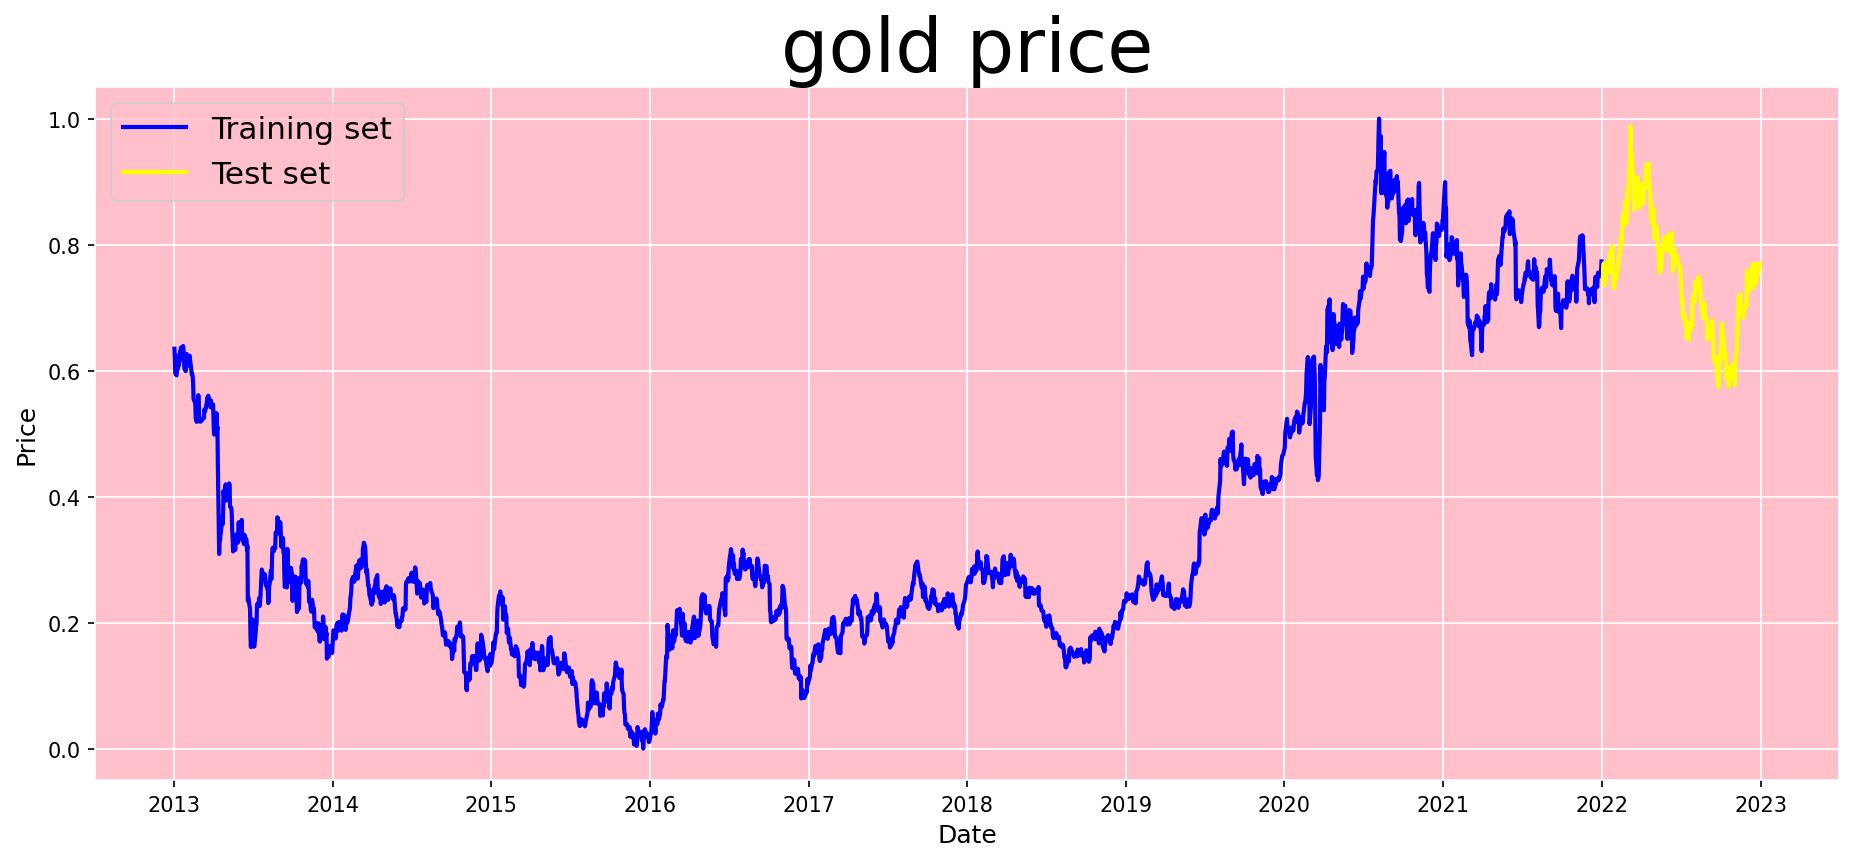

x_train shape :(2318, 5)
y_train shape :(2318,)
x_test shape :(260, 5)
y_test shape :(260,)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 5, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1254 - mae: 0.1254 - mse: 0.0282 - val_loss: 0.4424 - val_mae: 0.4424 - val_mse: 0.2018
Epoch 2/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0429 - mae: 0.0429 - mse: 0.0043 - val_loss: 0.2687 - val_mae: 0.2687 - val_mse: 0.0783
Epoch 3/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0270 - mae: 0.0270 - mse: 0.0013 - val_loss: 0.2289 - val_mae: 0.2289 - val_mse: 0.0580
Epoch 4/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0223 - mae: 0.0223 - mse: 9.4895e-04 - val_loss: 0.2054 - val_mae: 0.2054 - val_mse: 0.0477
Epoch 5/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0211 - mae: 0.0211 - mse: 8.1659e-04 - val_loss: 0.1895 - val_mae: 0.1895 - val_mse: 0.0413
Epoch 6/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0206 - mae: 0.0206 - mse: 7.5251e-04 - val_loss: 0.1801 - val_mae: 0.1801 - val_mse: 0.0377
Epoch 7/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0200 - mae: 0.0200 - mse: 7.

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1144 - mae: 0.1144 - mse: 0.0240 - val_loss: 0.5265 - val_mae: 0.5265 - val_mse: 0.2835
Epoch 2/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0809 - mae: 0.0809 - mse: 0.0132 - val_loss: 0.4780 - val_mae: 0.4780 - val_mse: 0.2347
Epoch 3/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0527 - mae: 0.0527 - mse: 0.0055 - val_loss: 0.2967 - val_mae: 0.2967 - val_mse: 0.0942
Epoch 4/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0387 - mae: 0.0387 - mse: 0.0025 - val_loss: 0.2701 - val_mae: 0.2701 - val_mse: 0.0791
Epoch 5/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0336 - mae: 0.0336 - mse: 0.0019 - val_loss: 0.2472 - val_mae: 0.2472 - val_mse: 0.0672
Epoch 6/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0328 - mae: 0.0328 - mse: 0.0019 - val_loss: 0.2298 - val_mae: 0.2298 - val_mse: 0.0587
Epoch 7/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0297 - mae: 0.0297 - mse: 0.0016 - val

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.1136 - mae: 0.1136 - mse: 0.0239 - val_loss: 0.5276 - val_mae: 0.5276 - val_mse: 0.2840
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0806 - mae: 0.0806 - mse: 0.0125 - val_loss: 0.5282 - val_mae: 0.5282 - val_mse: 0.2846
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0802 - mae: 0.0802 - mse: 0.0124 - val_loss: 0.5312 - val_mae: 0.5312 - val_mse: 0.2878
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0800 - mae: 0.0800 - mse: 0.0123 - val_loss: 0.5399 - val_mae: 0.5399 - val_mse: 0.2971
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0796 - mae: 0.0796 - mse: 0.0122 - val_loss: 0.5337 - val_mae: 0.5337 - val_mse: 0.2905
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0807 - mae: 0.0807 - mse: 0.0124 - val_loss: 0.5429 - val_mae: 0.5429 - val_mse: 0.3003
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0799 - mae: 0.0799 - mse: 0.0123 - val

In [ ]:
build_model_pipeline()

In [ ]:
# windows=[5,20,60,120,240]
# epochs=10
# testing_data=[]
# real_data=[]

# for window in windows:
#     x_train,y_train,x_test,y_test=build_train_test_dataset(
#         df,
#         test_size,
#         window
#     )
#     testing_data.append(x_test[0])
#     real_data.append(y_test[0])

#     model=build_model(window)
#     model=compile_model(model)

#     history=run_model(
#         model,
#         x_train,
#         y_train,
#         epochs=10
#     )

#     model_file_name=f"model_{window}_.h5"
#     model.save(model_file_name)


# for data in testing_data:
#     print(data)

# for data in real_data:
#     print(data)

NameError: name 'df' is not defined

In [ ]:
        #  df['Close'] ──► [LSTM: window=6] ─┐
        #                    prediction_6   │
        #  df['Close'] ──► [LSTM: window=20] ─┐
        #                    prediction_20   │
        #  df['Close'] ──► [LSTM: window=60] ─┐
        #                    prediction_60   │
        #  df['Close'] ──► [LSTM: window=120] ─┐
        #                    prediction_120   │──► [Sequential Meta Model] ─► Final Output
        #  df['Close'] ──► [LSTM: window=240] ─┘
        #                    prediction_240


In [ ]:
# windows = [5, 20, 60, 120, 240]
# meta_inputs = []
# real_outputs = None  # will be set once

# for window in windows:
#     model = load_model(f"lstm_window_{window}.h5")
#     x_train, y_train, x_test, y_test = build_train_test_dataset(df, test_size, window)

#     preds = model.predict(x_test)
#     meta_inputs.append(preds.reshape(-1, 1))  # reshape to column

#     if real_outputs is None:
#         real_outputs = y_test  # assuming all y_test are aligned

# # Stack predictions horizontally
# X_meta = np.hstack(meta_inputs)  # shape: (samples, 5)
# y_meta = real_outputs


In [ ]:
# def build_meta_model(input_dim=5):
#     model = Sequential()
#     model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
#     model.add(Dropout(0.2))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1))  # Predict final price
#     model.compile(optimizer='adam', loss='mse')
#     return model

# meta_model = build_meta_model()
# meta_model.fit(X_meta, y_meta, epochs=10, batch_size=32)

# # Save the meta model
# meta_model.save("meta_model.h5")


In [ ]:
# # Load LSTM models and meta-model
# lstm_models = [load_model(f"lstm_window_{w}.h5") for w in windows]
# meta_model = load_model("meta_model.h5")

# # Assume x_test from each LSTM model is available
# meta_input = []

# for i, window in enumerate(windows):
#     _, _, x_test, _ = build_train_test_dataset(df, test_size, window)
#     preds = lstm_models[i].predict(x_test)
#     meta_input.append(preds.reshape(-1, 1))

# meta_input = np.hstack(meta_input)  # shape: (samples, 5)

# final_predictions = meta_model.predict(meta_input)

# print(final_predictions[:5])
